# 7. Machine Learning Models - 2

In [1]:
#importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import os

import warnings
warnings.filterwarnings('ignore')

## 7.1 Utility Functions

### 7.1.1 Upsampling function

In [2]:
# ovrsampling training data only
# Ref: https://beckernick.github.io/oversampling-modeling/
from imblearn.over_sampling import SMOTE
def SMOTE_upsmapling(X, Y):
    smote = SMOTE()
    print('class label counts before upsampling :',np.bincount(Y.values.ravel()))
    X_ups,Y_ups = smote.fit_sample(X, Y)
    print('class label counts after upsampling :',np.bincount(Y_ups.values.ravel()))
    print('shapes after upsampling :',X_ups.shape, Y_ups.values.reshape(-1,).shape)
    return X_ups, Y_ups.values.reshape(-1,)

### 7.1.2 utility function for Hyperparameter tuning and for extracting & saving result values.

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc

def model_hyperparameter_tuning(classifier, parameters, X_train, Y_train):

    model = RandomizedSearchCV(estimator=classifier,n_jobs= -1,\
                               param_distributions=parameters,scoring='recall',\
                               verbose =5, n_iter = 15)
    model.fit(X_train,Y_train)
    print("Best parameters are:\n", model.best_params_)
    print("\nBest estimator is:\n", model.best_estimator_)
    print("\nAnd it's best recall score is :", model.best_score_)
    return model.best_estimator_

def cost_function(y_true, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    return fp*10 + fn*500

def score_table(classifier, datasets, threshold = 'default'):
    table = PrettyTable()
    table.field_names = ["Data", "Recall", "Precison", "F1-score","Cost"]
    for X,Y,data in [(datasets[0], y_train, "train"),(datasets[1], y_cv, "CV"), (datasets[2], y_test, "test")]:
        if threshold == 'default':
            Y_pred = classifier.predict(X)
        else:
            Y_pred = (classifier.predict_proba(X)[:,1] > threshold).astype(int)
        recall = np.round(recall_score(Y,Y_pred), 4)
        precision = np.round(precision_score(Y,Y_pred), 4)
        f1 = np.round(f1_score(Y,Y_pred), 4)
        cost = cost_function(Y, Y_pred)
        table.add_row([data, recall, precision, f1, cost ])
    print(table)
    
def plot_roc_curve(classifier, datasets):
    for X,Y,data in [(datasets[0], y_train, "train"),(datasets[1], y_cv, "CV"), (datasets[2], y_test, "test")]:
        Y_pred_prob = classifier.predict_proba(X)[:,1] 
        fpr, tpr, thresholds = roc_curve(Y, Y_pred_prob)
        plt.plot(fpr, tpr, label= data+ " AUC ="+str(auc(fpr, tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_predicted):
    class_labels = ['negative','positive']
    
    confusion_matrix_ = confusion_matrix(y_true, y_predicted)
    Precision_matrix = (confusion_matrix_/confusion_matrix_.sum(axis=0))
    recall_matrix = (((confusion_matrix_.T)/(confusion_matrix_.sum(axis=1))).T)
   
    plt.figure(figsize=(20,5))
    plt.suptitle("Confusion, Precison & Recall Matrix", fontsize=24)

    plt.subplot(1, 3, 1)
    sns.heatmap(confusion_matrix_, annot=True, fmt=".3f", xticklabels=class_labels, yticklabels=class_labels, cmap = 'YlGn')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(Precision_matrix, annot=True, fmt=".3f", xticklabels=class_labels, yticklabels=class_labels, cmap = 'YlGn')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(recall_matrix, annot=True, fmt=".3f", xticklabels=class_labels, yticklabels=class_labels, cmap = 'YlGn')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Recall matrix")    
    plt.show()

    tn, fp, fn, tp = confusion_matrix_.ravel()
    cost = fp*10 + fn*500
    print('#False positives(Type 1 error) :', fp)
    print('#False negatives(Type 2 error) :', fn)
    print('cost :', cost)
    
def select_threshold(Y, Y_pred_prob):
    #Y_pred_prob = classifier.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(Y, Y_pred_prob)
    thresholds = np.append(thresholds,1)

    costs_array = []

    for threshold in thresholds:
        Y_hat = Y_pred_prob > threshold
        costs_array.append(cost_function(Y, Y_hat))
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,2,1)
    plt.plot(thresholds, costs_array, label='Costs', linestyle = 'solid', linewidth = 2)
    plt.xlabel("Thresholds")
    plt.ylabel("Costs")
    plt.title("Cost vs Threshold Plot")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(thresholds, precision, label='Precision', linestyle = 'solid', linewidth = 2)
    plt.plot(thresholds, recall, label='Recall', linestyle = 'solid', linewidth = 2)
    plt.xlabel("Thresholds")
    plt.ylabel("Precision & Recall")
    plt.title("Precision&Recall vs Threshold Plot")    
    plt.grid()
    plt.legend()

    plt.show()
    
    best_threshold_index = np.argsort(costs_array)[0]
    best_threshold = thresholds[best_threshold_index]
    min_cost = costs_array[best_threshold_index]
    print("Best threshold: {:.4f}".format(best_threshold))
    print("cost at this thresold: {:.2f}".format(min_cost))
    return best_threshold

def save_results(classifier,imp_meth, threshold,Y, Y_pred, feat_eng ):
    column_names = ['Imputation','Model','Threshold', 'Recall', \
                    'Precision', 'Cost', 'F1-Score', '#FalsePostives',\
                    '#FalseNegatives','Feature Engineering']
    
    if not os.path.isfile('ML models & Results/results.csv'):
        results = pd.DataFrame(columns = column_names)
    else:
        results = pd.read_csv('ML models & Results/results.csv')
    recall = np.round(recall_score(Y,Y_pred), 4)
    precision = np.round(precision_score(Y,Y_pred), 4)
    f1 = np.round(f1_score(Y,Y_pred), 4) 
    tn, fp, fn, tp = confusion_matrix(y_test, Y_pred).ravel()
    cost = fp*10 + fn*500
    row = pd.DataFrame([[imp_meth, classifier, threshold, recall, precision, cost, f1, fp, fn, feat_eng ]],\
                       columns = column_names)
    results = results.append(row,ignore_index=True)
    results.to_csv('ML models & Results/results.csv')

In [4]:
#Loading y_train, y_cv and y_test
y_train = pd.read_csv('y_train.csv', header = None)
y_cv = pd.read_csv('y_cv.csv', header = None)
y_test = pd.read_csv('y_test.csv', header = None)

In [5]:
x_tr_mis_ind = pd.read_csv('x_tr_mis_ind.csv')
x_cv_mis_ind = pd.read_csv('x_cv_mis_ind.csv')
x_te_mis_ind = pd.read_csv('x_te_mis_ind.csv')

## 7.2 Median Imputed + Missing Indicator Dataset

### 7.2.1 loading Train, CV & Test datasets & Upsampling train dataset

In [6]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_med = pd.read_csv('x_tr_med.csv')
x_cv_med = pd.read_csv('x_cv_med.csv')
x_te_med = pd.read_csv('x_te_med.csv')

x_tr_med_with_ind = pd.concat([x_tr_med, x_tr_mis_ind], axis=1, sort=False)
x_cv_med_with_ind = pd.concat([x_cv_med, x_cv_mis_ind], axis=1, sort=False)
x_te_med_with_ind = pd.concat([x_te_med, x_te_mis_ind], axis=1, sort=False)

print('Shapes of Train, CV & Test data of :')
print(x_tr_med_with_ind.shape, x_cv_med_with_ind.shape, x_te_med_with_ind.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_med_with_ind,y_train = SMOTE_upsmapling(x_tr_med_with_ind, y_train)

Shapes of Train, CV & Test data of :
(51000, 340) (9000, 340) (16000, 340)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 340) (100300,)


### 7.2.2 RandomForestClassifier on Median Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 30.0min finished


Best parameters are:
 {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=4, min_samples_split=6,
                       random_state=42)

And it's best recall score is : 0.9917048853439681

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9916 |  0.9887  |  0.9901  | 216200 |
|   CV  |  0.9   |  0.4821  |  0.6279  |  8950  |
|  test | 0.9147 |  0.6103  |  0.7321  | 18190  |
+-------+--------+----------+----------+--------+


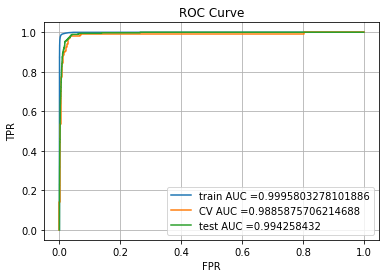

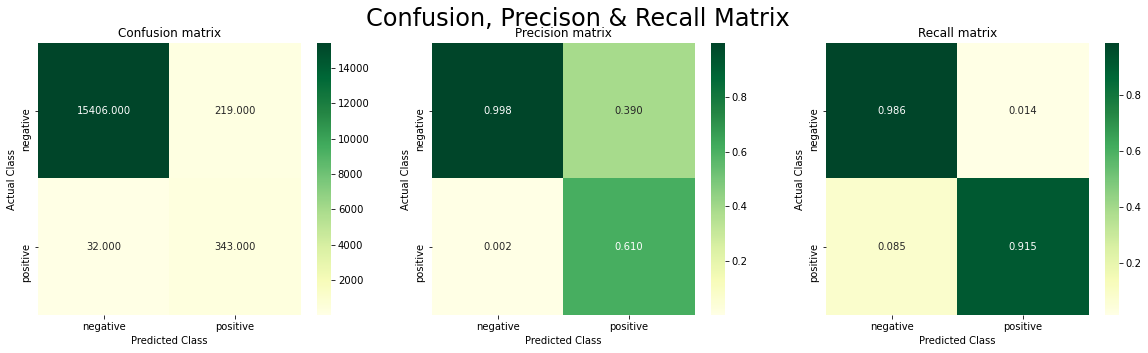

#False positives(Type 1 error) : 219
#False negatives(Type 2 error) : 32
cost : 18190
Selecting best threshold that gives lowest cost


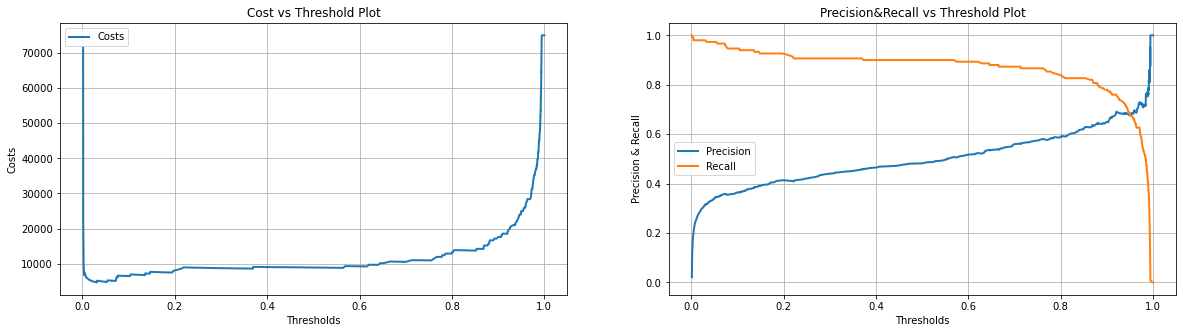

Best threshold: 0.0312
cost at this thresold: 4660.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.998  |  0.969   |  0.9833  | 65510 |
|   CV  |  0.98  |  0.3175  |  0.4796  |  4660 |
|  test | 0.9733 |  0.4087  |  0.5757  | 10280 |
+-------+--------+----------+----------+-------+


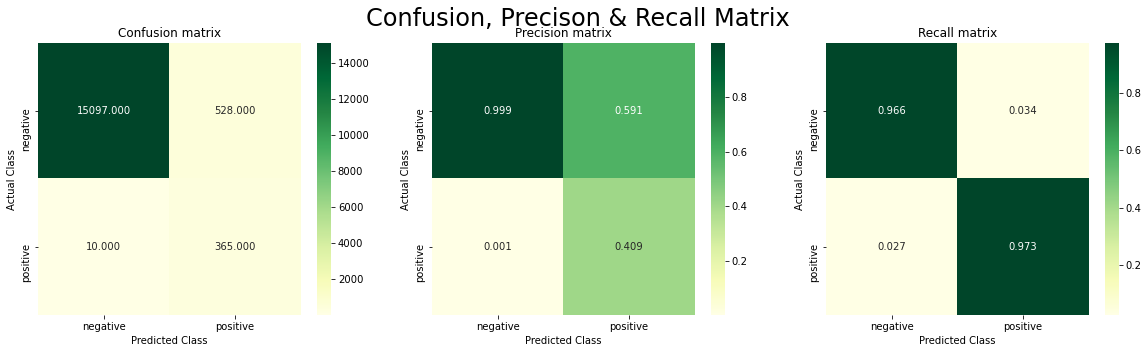

#False positives(Type 1 error) : 528
#False negatives(Type 2 error) : 10
cost : 10280


['ML models & Results/med_with_ind_RF.pkl']

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_med_with_ind, y_train))
best_clf.fit(x_tr_med_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_med_with_ind, x_cv_med_with_ind, x_te_med_with_ind])
plot_roc_curve(best_clf, [x_tr_med_with_ind, x_cv_med_with_ind, x_te_med_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_med_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_med_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_med_with_ind, x_cv_med_with_ind, x_te_med_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_med_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','median', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/med_with_ind_RF.pkl')

### 7.2.3 XGBClassifier on Median Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 93.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 125.7min finished


Best parameters are:
 {'subsample': 1, 'n_estimators': 1000, 'max_depth': 11, 'learning_rate': 0.03, 'colsample_bytree': 0.1}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9994815553339981

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |   1.0

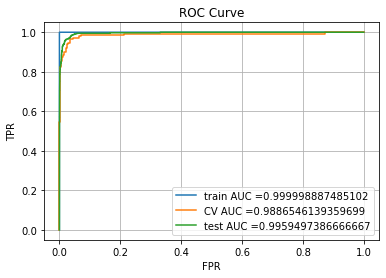

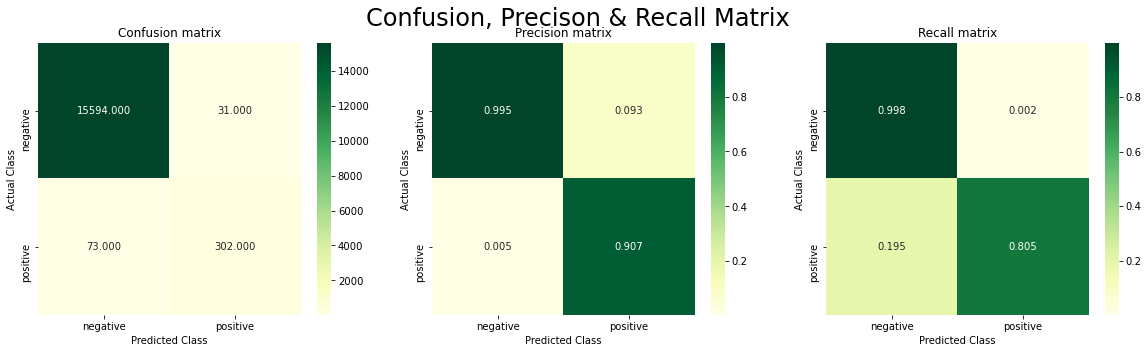

#False positives(Type 1 error) : 31
#False negatives(Type 2 error) : 73
cost : 36810
Selecting best threshold that gives lowest cost


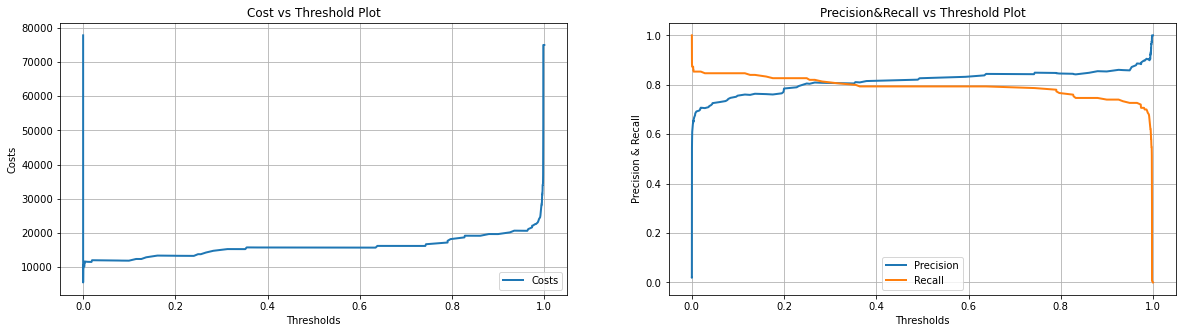

Best threshold: 0.0003
cost at this thresold: 5530.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9759  |  0.9878  | 12870 |
|   CV  | 0.9667 |  0.3237  |  0.4849  |  5530 |
|  test | 0.968  |  0.4332  |  0.5985  | 10750 |
+-------+--------+----------+----------+-------+


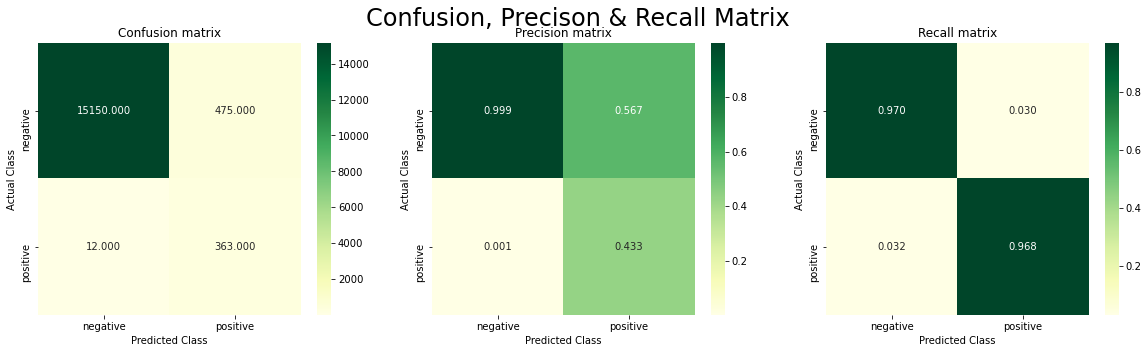

#False positives(Type 1 error) : 475
#False negatives(Type 2 error) : 12
cost : 10750


['ML models & Results/med_with_ind_XGB.pkl']

In [8]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_med_with_ind, y_train))
best_clf.fit(x_tr_med_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_med_with_ind, x_cv_med_with_ind, x_te_med_with_ind])
plot_roc_curve(best_clf, [x_tr_med_with_ind, x_cv_med_with_ind, x_te_med_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_med_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_med_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_med_with_ind, x_cv_med_with_ind, x_te_med_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_med_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','median', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/med_with_ind_XGB.pkl')

## 7.3 KNNImputer Imputed + Missing Indicator Dataset

### 7.3.1 loading Train, CV & Test datasets & Upsampling train dataset

In [9]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_KNN = pd.read_csv('x_tr_KNN.csv')
x_cv_KNN = pd.read_csv('x_cv_KNN.csv')
x_te_KNN = pd.read_csv('x_te_KNN.csv')

x_tr_KNN_with_ind = pd.concat([x_tr_KNN, x_tr_mis_ind], axis=1, sort=False)
x_cv_KNN_with_ind = pd.concat([x_cv_KNN, x_cv_mis_ind], axis=1, sort=False)
x_te_KNN_with_ind = pd.concat([x_te_KNN, x_te_mis_ind], axis=1, sort=False)

print('Shapes of Train, CV & Test data of :')
print(x_tr_KNN_with_ind.shape, x_cv_KNN_with_ind.shape, x_te_KNN_with_ind.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_KNN_with_ind,y_train = SMOTE_upsmapling(x_tr_KNN_with_ind, y_train)

Shapes of Train, CV & Test data of :
(51000, 340) (9000, 340) (16000, 340)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 340) (100300,)


### 7.3.2 RandomForestClassifier on KNNImputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 43.5min finished


Best parameters are:
 {'n_estimators': 800, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=800, random_state=42)

And it's best recall score is : 0.993878364905284

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9935 |  0.9895  |  0.9915  | 169280 |
|   CV  | 0.8867 |  0.5038  |  0.6425  |  9810  |
|  test | 0.9013 |  0.6168  |  0.7324  | 20600  |
+-------+--------+----------+----------+--------+


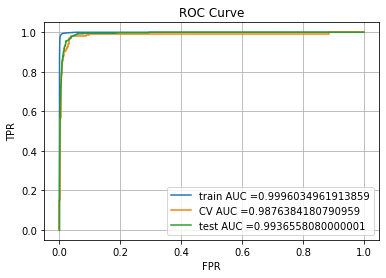

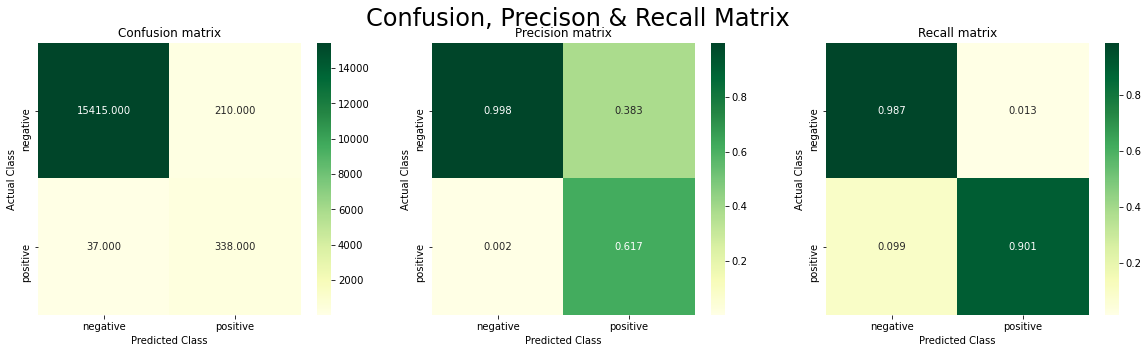

#False positives(Type 1 error) : 210
#False negatives(Type 2 error) : 37
cost : 20600
Selecting best threshold that gives lowest cost


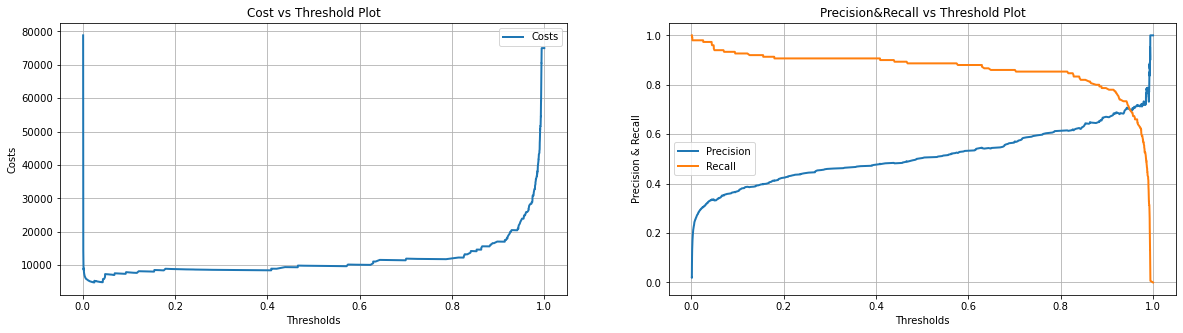

Best threshold: 0.0254
cost at this thresold: 4840.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9977 |  0.9684  |  0.9829  | 74300 |
|   CV  |  0.98  |  0.3056  |  0.4659  |  4840 |
|  test | 0.9707 |   0.4    |  0.5665  | 10960 |
+-------+--------+----------+----------+-------+


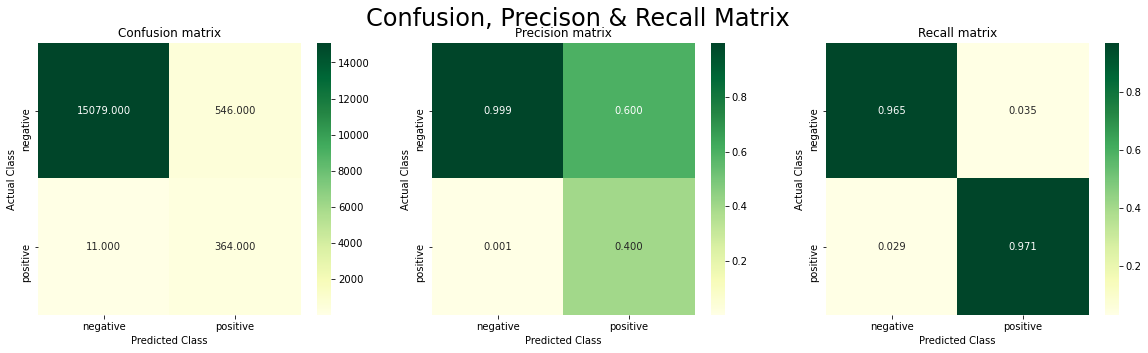

#False positives(Type 1 error) : 546
#False negatives(Type 2 error) : 11
cost : 10960


['ML models & Results/KNNimp_with_ind_RF.pkl']

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_KNN_with_ind, y_train))
best_clf.fit(x_tr_KNN_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_KNN_with_ind, x_cv_KNN_with_ind, x_te_KNN_with_ind])
plot_roc_curve(best_clf, [x_tr_KNN_with_ind, x_cv_KNN_with_ind, x_te_KNN_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_KNN_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_KNN_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_KNN_with_ind, x_cv_KNN_with_ind, x_te_KNN_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_KNN_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','KNNimputer', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_with_ind_RF.pkl')

### 7.3.3 XGBClassifier on KNNImputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 126.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 147.1min finished


Best parameters are:
 {'subsample': 1, 'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.2, 'colsample_bytree': 0.1}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9995613160518444

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |   1.0  

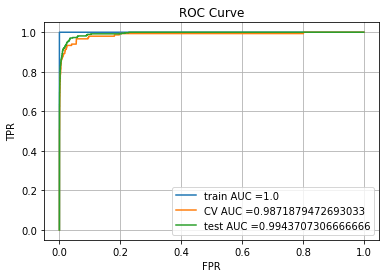

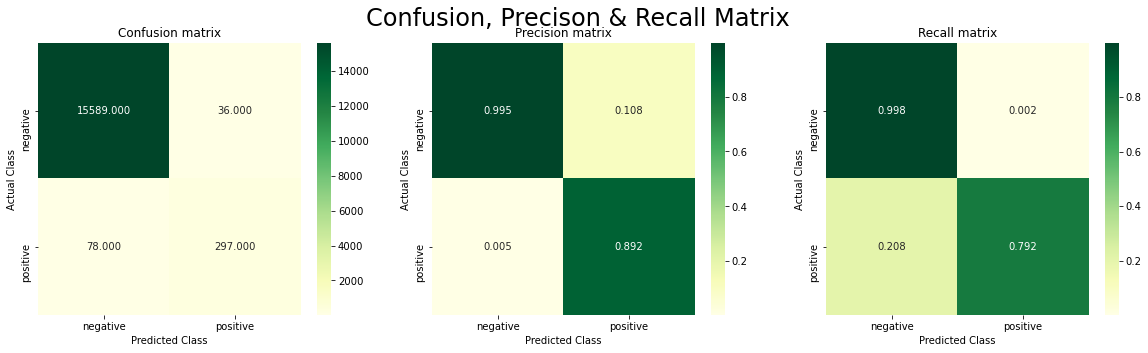

#False positives(Type 1 error) : 36
#False negatives(Type 2 error) : 78
cost : 39360
Selecting best threshold that gives lowest cost


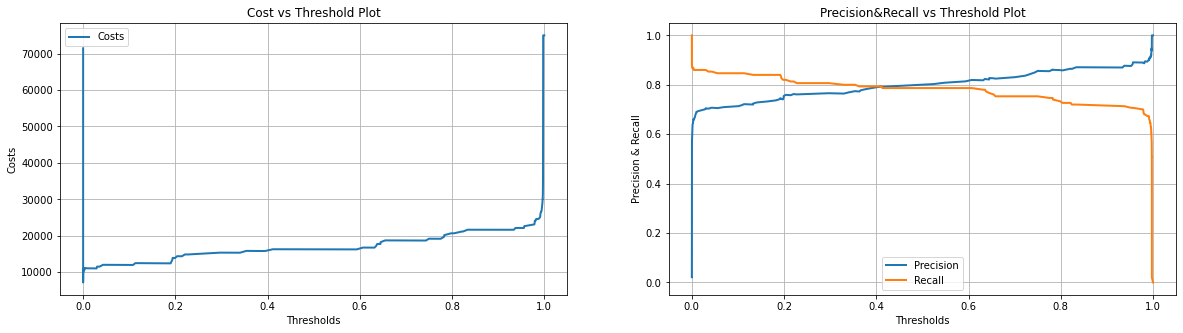

Best threshold: 0.0003
cost at this thresold: 7190.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9864  |  0.9932  |  6890 |
|   CV  | 0.9333 |   0.39   |  0.5501  |  7190 |
|  test | 0.9467 |  0.485   |  0.6414  | 13770 |
+-------+--------+----------+----------+-------+


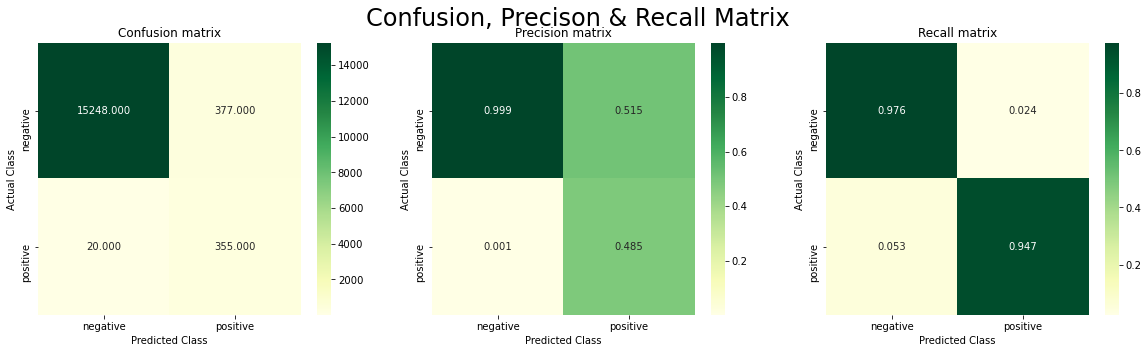

#False positives(Type 1 error) : 377
#False negatives(Type 2 error) : 20
cost : 13770


['ML models & Results/KNNimp_with_ind_XGB.pkl']

In [11]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_KNN_with_ind, y_train))
best_clf.fit(x_tr_KNN_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_KNN_with_ind, x_cv_KNN_with_ind, x_te_KNN_with_ind])
plot_roc_curve(best_clf, [x_tr_KNN_with_ind, x_cv_KNN_with_ind, x_te_KNN_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_KNN_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_KNN_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_KNN_with_ind, x_cv_KNN_with_ind, x_te_KNN_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_KNN_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','KNNimputer', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_with_ind_XGB.pkl')

## 7.4 BayesianRidge_imputer Imputed + Missing Indicator Dataset

### 7.4.1 loading Train, CV & Test datasets & Upsampling train dataset

In [12]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_BR = pd.read_csv('x_tr_BR.csv')
x_cv_BR = pd.read_csv('x_cv_BR.csv')
x_te_BR = pd.read_csv('x_te_BR.csv')

x_tr_BR_with_ind = pd.concat([x_tr_BR, x_tr_mis_ind], axis=1, sort=False)
x_cv_BR_with_ind = pd.concat([x_cv_BR, x_cv_mis_ind], axis=1, sort=False)
x_te_BR_with_ind = pd.concat([x_te_BR, x_te_mis_ind], axis=1, sort=False)

print('Shapes of Train, CV & Test data of :')
print(x_tr_BR_with_ind.shape, x_cv_BR_with_ind.shape, x_te_BR_with_ind.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_BR_with_ind,y_train = SMOTE_upsmapling(x_tr_BR_with_ind, y_train)

Shapes of Train, CV & Test data of :
(51000, 340) (9000, 340) (16000, 340)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 340) (100300,)


### 7.4.2 RandomForestClassifier on BayesianRidge_imputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 35.9min finished


Best parameters are:
 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=8, n_estimators=500,
                       random_state=42)

And it's best recall score is : 0.9916450648055832

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9912 |  0.9873  |  0.9893  | 226890 |
|   CV  | 0.9067 |  0.4739  |  0.6224  |  8510  |
|  test | 0.9173 |  0.5931  |  0.7204  | 17860  |
+-------+--------+----------+----------+--------+


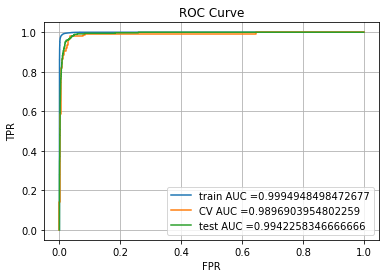

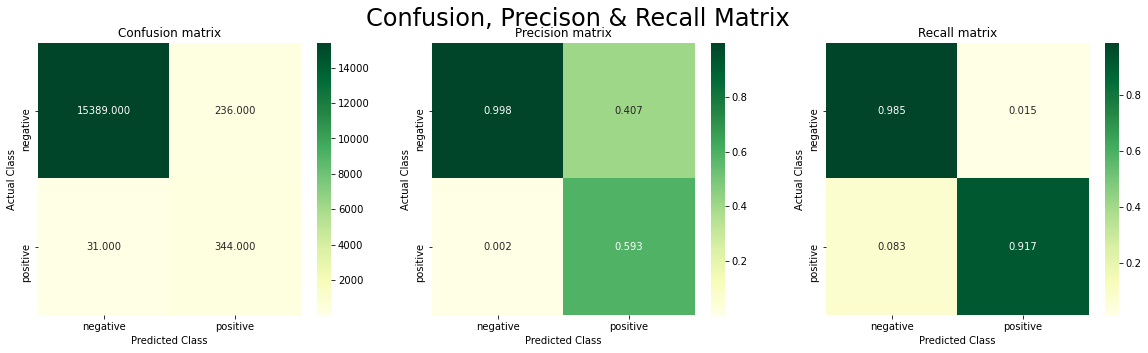

#False positives(Type 1 error) : 236
#False negatives(Type 2 error) : 31
cost : 17860
Selecting best threshold that gives lowest cost


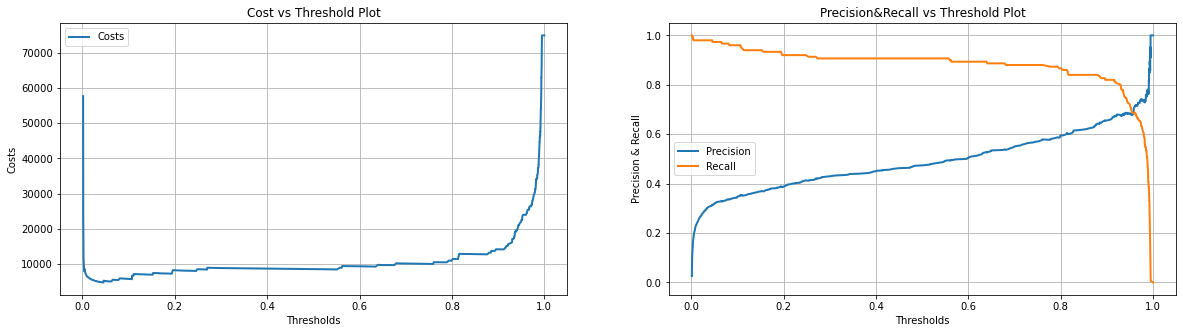

Best threshold: 0.0457
cost at this thresold: 4700.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9972 |  0.9684  |  0.9826  | 87300 |
|   CV  |  0.98  |  0.3148  |  0.4765  |  4700 |
|  test | 0.9707 |  0.4035  |  0.5701  | 10880 |
+-------+--------+----------+----------+-------+


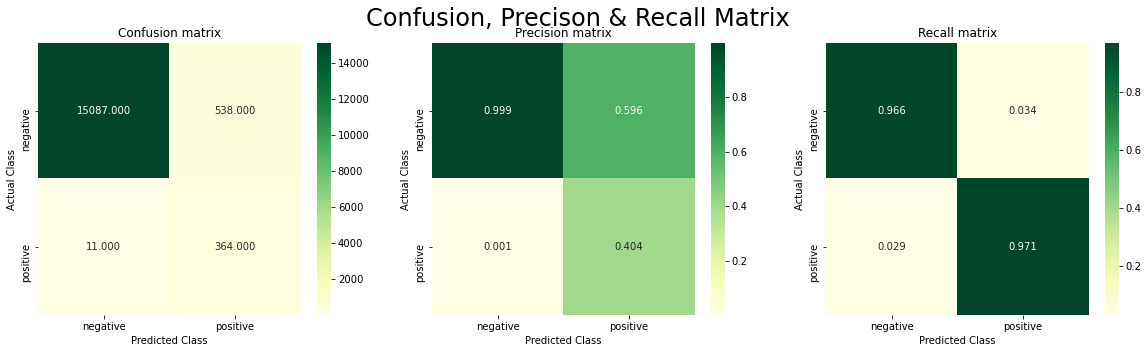

#False positives(Type 1 error) : 538
#False negatives(Type 2 error) : 11
cost : 10880


['ML models & Results/BRitimp_with_ind_RF.pkl']

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BR_with_ind, y_train))
best_clf.fit(x_tr_BR_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BR_with_ind, x_cv_BR_with_ind, x_te_BR_with_ind])
plot_roc_curve(best_clf, [x_tr_BR_with_ind, x_cv_BR_with_ind, x_te_BR_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BR_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BR_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BR_with_ind, x_cv_BR_with_ind, x_te_BR_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BR_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_with_ind_RF.pkl')

### 7.4.3 XGBClassifier on BayesianRidge_imputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 120.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 151.3min finished


Best parameters are:
 {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.15, 'colsample_bytree': 0.3}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9995812562313061

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |   1

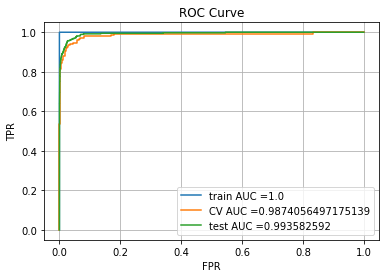

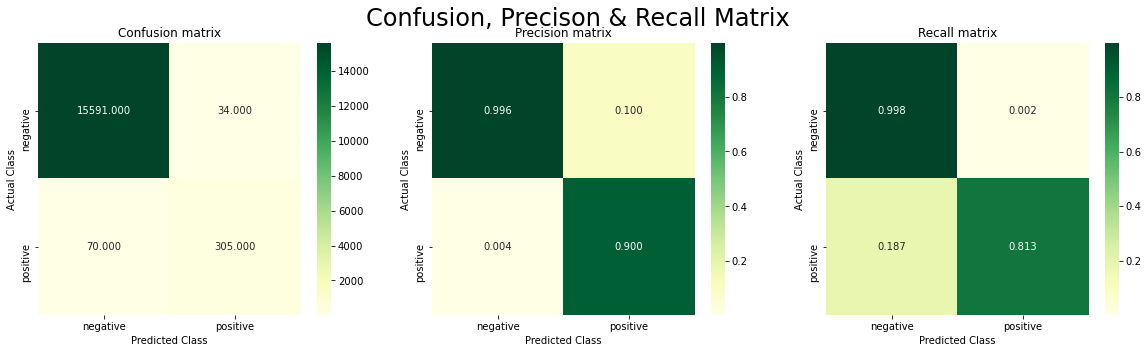

#False positives(Type 1 error) : 34
#False negatives(Type 2 error) : 70
cost : 35340
Selecting best threshold that gives lowest cost


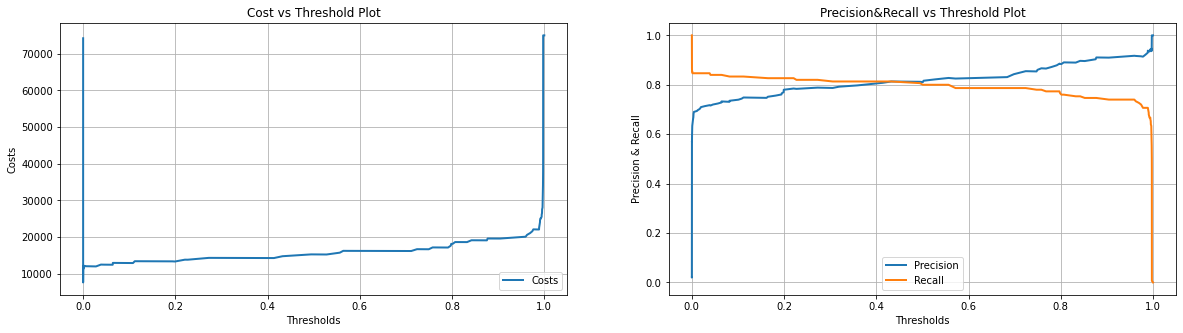

Best threshold: 0.0002
cost at this thresold: 7630.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.981   |  0.9904  |  9710 |
|   CV  | 0.9333 |  0.3474  |  0.5063  |  7630 |
|  test | 0.9547 |  0.4625  |  0.6232  | 12660 |
+-------+--------+----------+----------+-------+


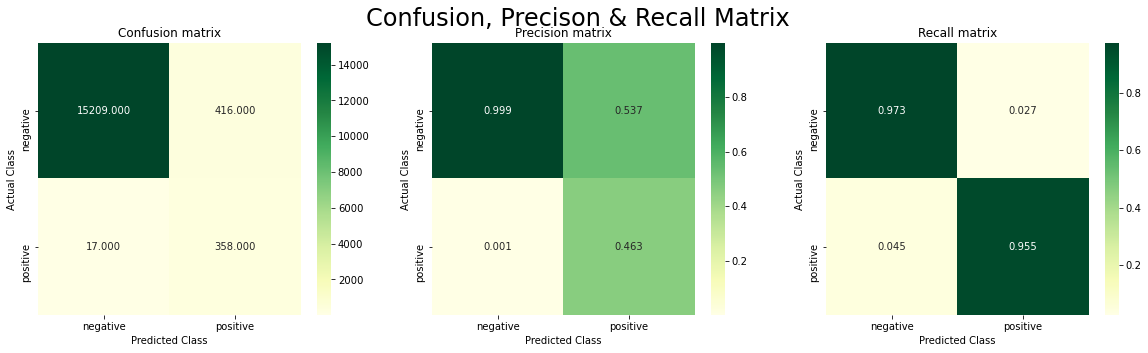

#False positives(Type 1 error) : 416
#False negatives(Type 2 error) : 17
cost : 12660


['ML models & Results/BRitimp_with_ind_XGB.pkl']

In [14]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BR_with_ind, y_train))
best_clf.fit(x_tr_BR_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BR_with_ind, x_cv_BR_with_ind, x_te_BR_with_ind])
plot_roc_curve(best_clf, [x_tr_BR_with_ind, x_cv_BR_with_ind, x_te_BR_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BR_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BR_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BR_with_ind, x_cv_BR_with_ind, x_te_BR_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BR_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_with_ind_XGB.pkl')

## 7.5 RandomForestRegressor_imputer Imputed + Missing Indicator Dataset

### 7.5.1 loading Train, CV & Test datasets & Upsampling train dataset

In [6]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_RF = pd.read_csv('x_tr_RF.csv')
x_cv_RF = pd.read_csv('x_cv_RF.csv')
x_te_RF = pd.read_csv('x_te_RF.csv')

x_tr_RF_with_ind = pd.concat([x_tr_RF, x_tr_mis_ind], axis=1, sort=False)
x_cv_RF_with_ind = pd.concat([x_cv_RF, x_cv_mis_ind], axis=1, sort=False)
x_te_RF_with_ind = pd.concat([x_te_RF, x_te_mis_ind], axis=1, sort=False)

print('Shapes of Train, CV & Test data of :')
print(x_tr_RF_with_ind.shape, x_cv_RF_with_ind.shape, x_te_RF_with_ind.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_RF_with_ind,y_train = SMOTE_upsmapling(x_tr_RF_with_ind, y_train)

Shapes of Train, CV & Test data of :
(51000, 340) (9000, 340) (16000, 340)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 340) (100300,)


### 7.5.2 RandomForestClassifier on RandomForestRegressor_imputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 48.0min finished


Best parameters are:
 {'n_estimators': 500, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=9, min_samples_split=9,
                       n_estimators=500, random_state=42)

And it's best recall score is : 0.9904287138584248

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9899 |  0.9869  |  0.9884  | 260100 |
|   CV  | 0.8867 |  0.4586  |  0.6045  | 10070  |
|  test | 0.9333 |  0.6076  |  0.7361  | 14760  |
+-------+--------+----------+----------+--------+


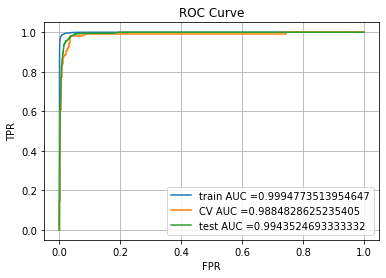

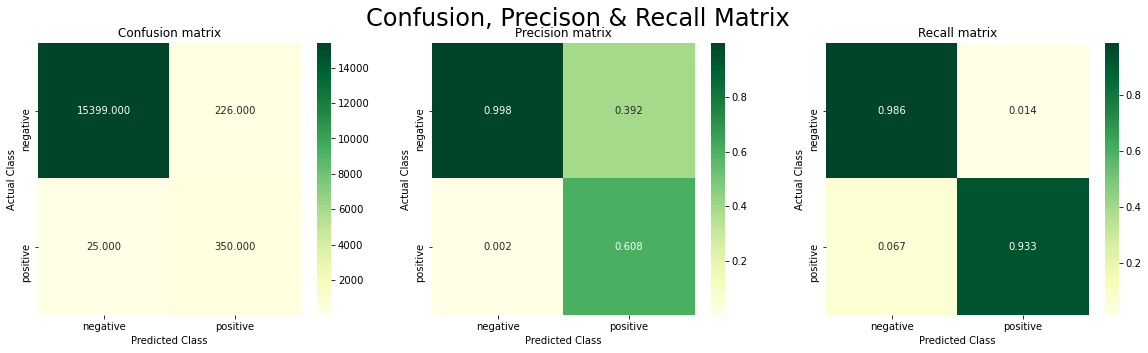

#False positives(Type 1 error) : 226
#False negatives(Type 2 error) : 25
cost : 14760
Selecting best threshold that gives lowest cost


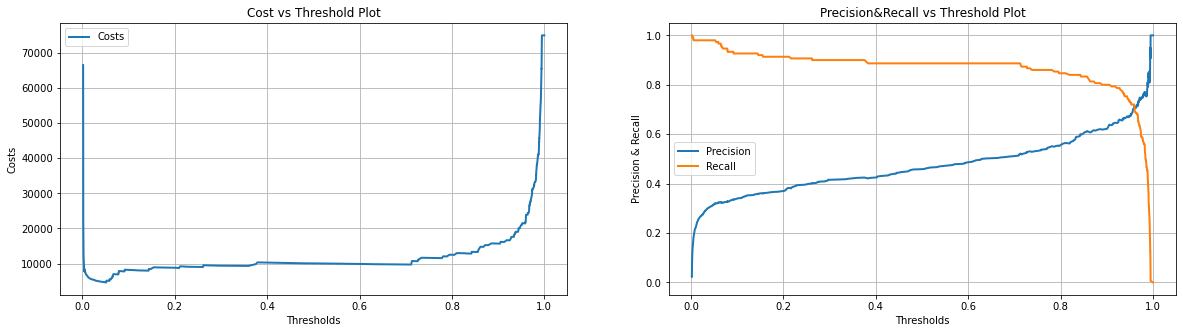

Best threshold: 0.0515
cost at this thresold: 4620.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9965 |  0.9688  |  0.9824  | 104620 |
|   CV  |  0.98  |  0.3203  |  0.4828  |  4620  |
|  test | 0.9733 |  0.4087  |  0.5757  | 10280  |
+-------+--------+----------+----------+--------+


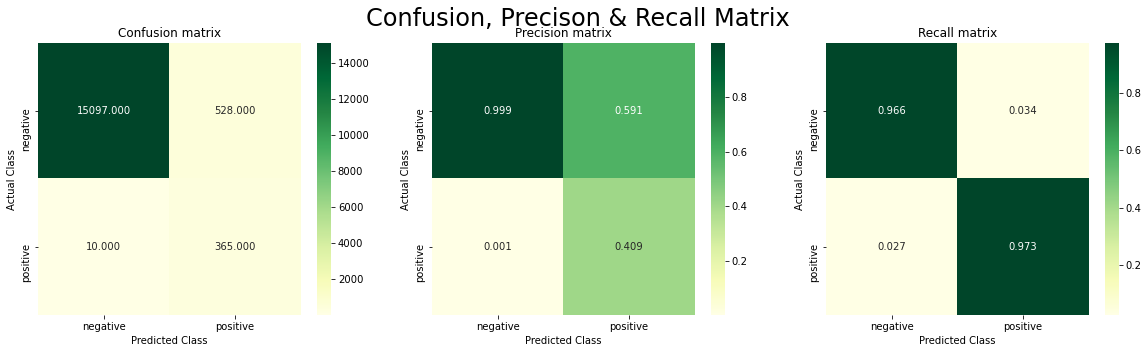

#False positives(Type 1 error) : 528
#False negatives(Type 2 error) : 10
cost : 10280


['ML models & Results/RFR_with_ind_RF.pkl']

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_RF_with_ind, y_train))
best_clf.fit(x_tr_RF_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_RF_with_ind, x_cv_RF_with_ind, x_te_RF_with_ind])
plot_roc_curve(best_clf, [x_tr_RF_with_ind, x_cv_RF_with_ind, x_te_RF_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_RF_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_RF_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_RF_with_ind, x_cv_RF_with_ind, x_te_RF_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_RF_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/RFR_with_ind_RF.pkl')

### 7.5.3 XGBClassifier on RandomForestRegressor_imputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 120.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 152.1min finished


Best parameters are:
 {'subsample': 0.3, 'n_estimators': 700, 'max_depth': 12, 'learning_rate': 0.2, 'colsample_bytree': 0.3}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9992422731804588

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |   1.0

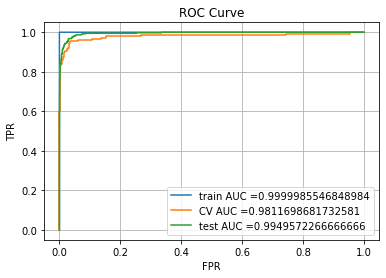

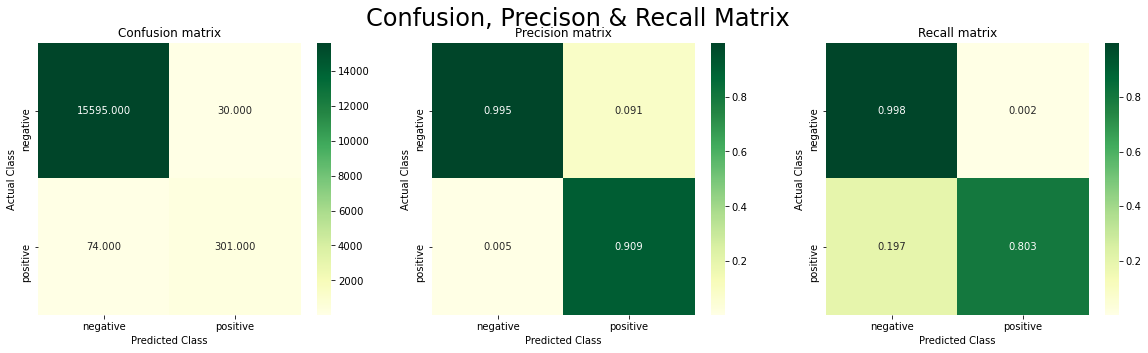

#False positives(Type 1 error) : 30
#False negatives(Type 2 error) : 74
cost : 37300
Selecting best threshold that gives lowest cost


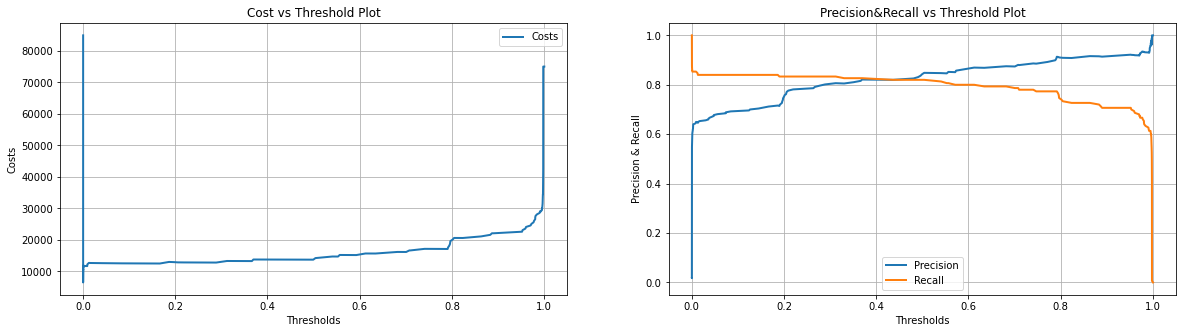

Best threshold: 0.0004
cost at this thresold: 6490.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9734  |  0.9865  | 14180 |
|   CV  | 0.9533 |  0.3235  |  0.4831  |  6490 |
|  test | 0.968  |  0.4271  |  0.5927  | 10870 |
+-------+--------+----------+----------+-------+


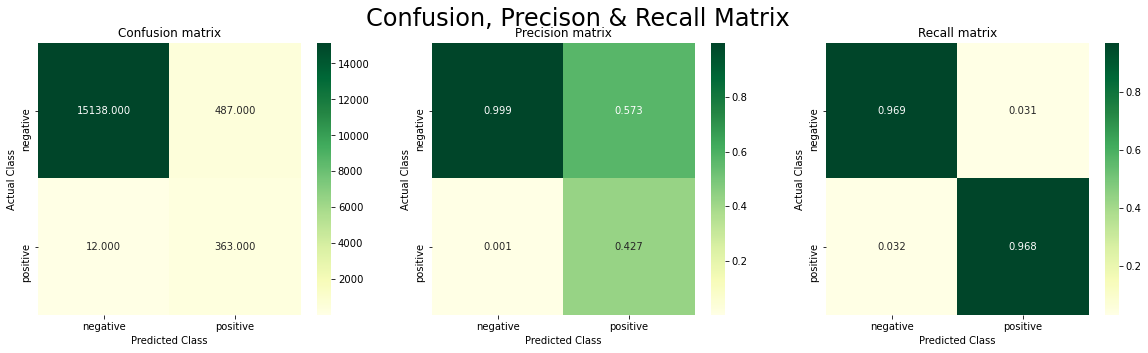

#False positives(Type 1 error) : 487
#False negatives(Type 2 error) : 12
cost : 10870


['ML models & Results/RFR_with_ind_XGB.pkl']

In [7]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_RF_with_ind, y_train))
best_clf.fit(x_tr_RF_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_RF_with_ind, x_cv_RF_with_ind, x_te_RF_with_ind])
plot_roc_curve(best_clf, [x_tr_RF_with_ind, x_cv_RF_with_ind, x_te_RF_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_RF_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_RF_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_RF_with_ind, x_cv_RF_with_ind, x_te_RF_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_RF_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/RFR_with_ind_XGB.pkl')

## 7.6 BayesianGaussianMixture_imputer Imputed + Missing Indicator Dataset

### 7.6.1 loading Train, CV & Test datasets & Upsampling train dataset

In [8]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_BGM = pd.read_csv('x_tr_BGM.csv')
x_cv_BGM = pd.read_csv('x_cv_BGM.csv')
x_te_BGM = pd.read_csv('x_te_BGM.csv')

x_tr_BGM_with_ind = pd.concat([x_tr_BGM, x_tr_mis_ind], axis=1, sort=False)
x_cv_BGM_with_ind = pd.concat([x_cv_BGM, x_cv_mis_ind], axis=1, sort=False)
x_te_BGM_with_ind = pd.concat([x_te_BGM, x_te_mis_ind], axis=1, sort=False)

print('Shapes of Train, CV & Test data of :')
print(x_tr_BGM_with_ind.shape, x_cv_BGM_with_ind.shape, x_te_BGM_with_ind.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_BGM_with_ind,y_train = SMOTE_upsmapling(x_tr_BGM_with_ind, y_train)

Shapes of Train, CV & Test data of :
(51000, 340) (9000, 340) (16000, 340)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 340) (100300,)


### 7.6.2 RandomForestClassifier on BayesianGaussianMixture_imputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 37.2min finished


Best parameters are:
 {'n_estimators': 600, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=11, min_samples_split=3,
                       n_estimators=600, random_state=42)

And it's best recall score is : 0.9908873379860419

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9903 |  0.9851  |  0.9877  | 250510 |
|   CV  | 0.8933 |  0.4512  |  0.5996  |  9630  |
|  test | 0.9227 |  0.5796  |  0.7119  | 17010  |
+-------+--------+----------+----------+--------+


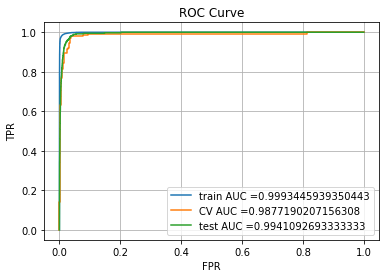

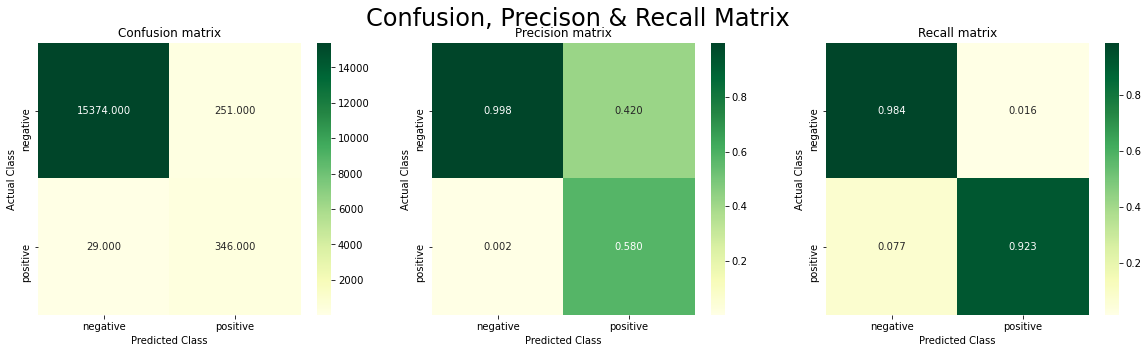

#False positives(Type 1 error) : 251
#False negatives(Type 2 error) : 29
cost : 17010
Selecting best threshold that gives lowest cost


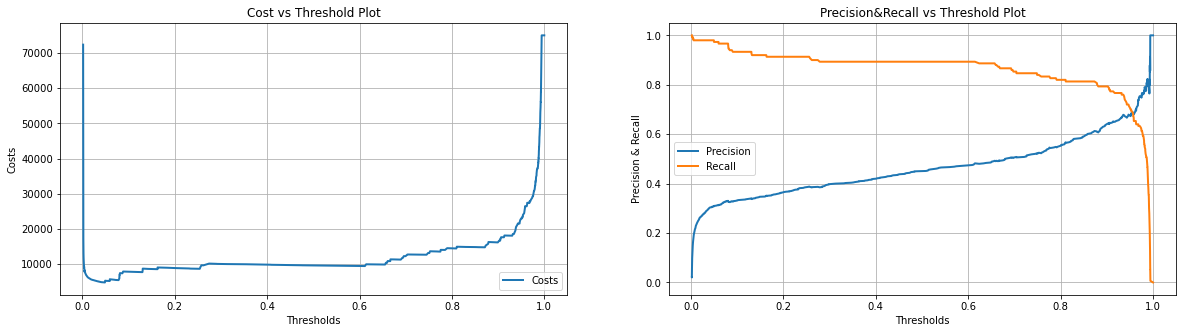

Best threshold: 0.0489
cost at this thresold: 4780.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9969 |  0.9667  |  0.9816  | 94220 |
|   CV  |  0.98  |  0.3095  |  0.4704  |  4780 |
|  test | 0.976  |  0.3996  |  0.567   | 10000 |
+-------+--------+----------+----------+-------+


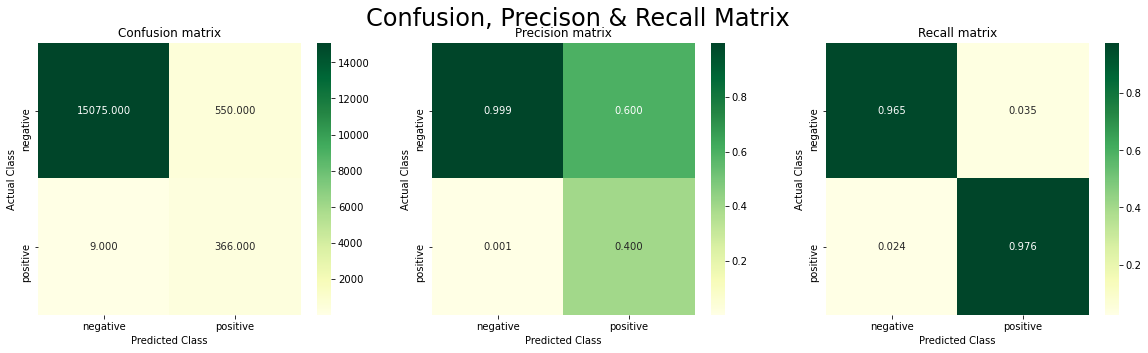

#False positives(Type 1 error) : 550
#False negatives(Type 2 error) : 9
cost : 10000


['ML models & Results/BGM_with_ind_RF.pkl']

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BGM_with_ind, y_train))
best_clf.fit(x_tr_BGM_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BGM_with_ind, x_cv_BGM_with_ind, x_te_BGM_with_ind])
plot_roc_curve(best_clf, [x_tr_BGM_with_ind, x_cv_BGM_with_ind, x_te_BGM_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BGM_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BGM_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BGM_with_ind, x_cv_BGM_with_ind, x_te_BGM_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BGM_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/BGM_with_ind_RF.pkl')

### 7.6.3 XGBClassifier on BayesianGaussianMixture_imputer Imputed + Missing Indicator Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 99.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 115.7min finished


Best parameters are:
 {'subsample': 0.5, 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.03, 'colsample_bytree': 0.1}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9994416749750747

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9997 |  0.

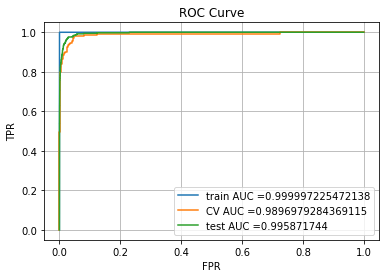

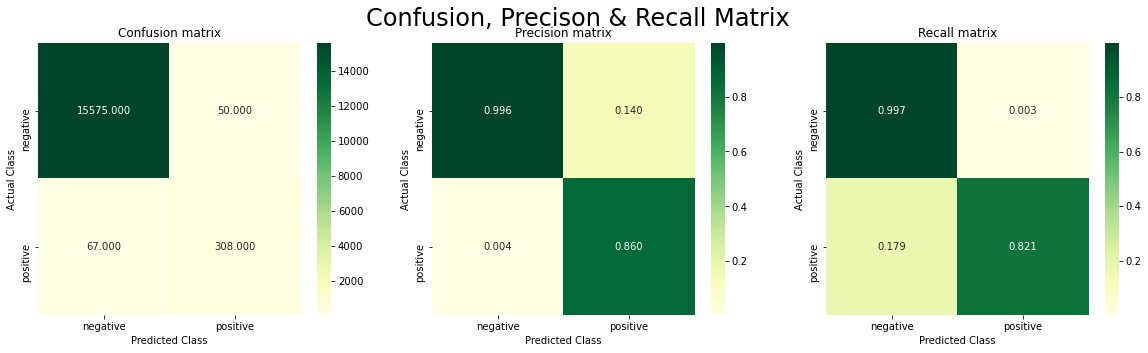

#False positives(Type 1 error) : 50
#False negatives(Type 2 error) : 67
cost : 34000
Selecting best threshold that gives lowest cost


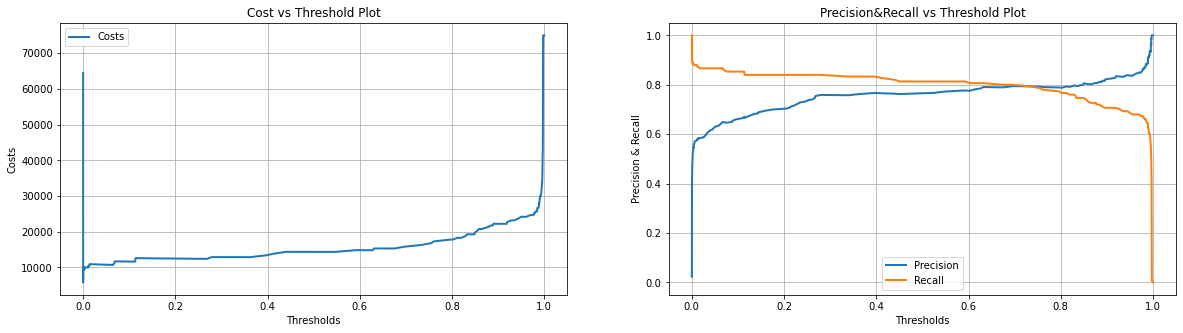

Best threshold: 0.0002
cost at this thresold: 5800.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9591  |  0.9791  | 22410 |
|   CV  |  0.98  |  0.2548  |  0.4044  |  5800 |
|  test | 0.984  |  0.3376  |  0.5027  | 10240 |
+-------+--------+----------+----------+-------+


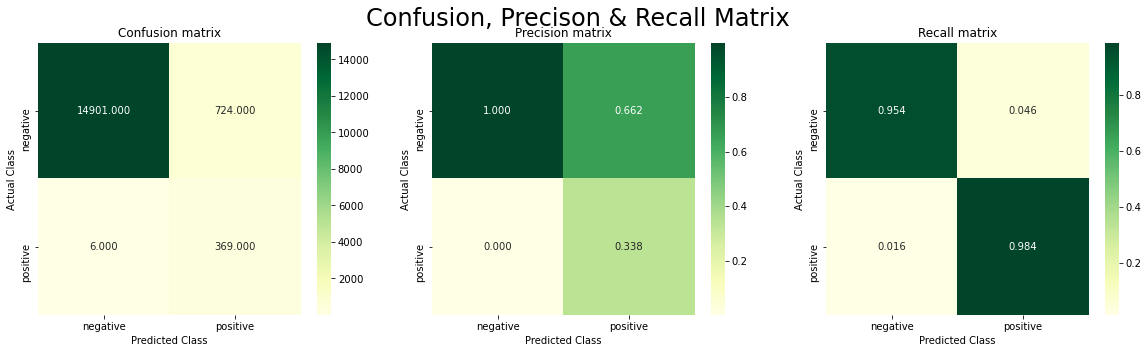

#False positives(Type 1 error) : 724
#False negatives(Type 2 error) : 6
cost : 10240


['ML models & Results/BGM_with_ind_XGB.pkl']

In [10]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BGM_with_ind, y_train))
best_clf.fit(x_tr_BGM_with_ind,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BGM_with_ind, x_cv_BGM_with_ind, x_te_BGM_with_ind])
plot_roc_curve(best_clf, [x_tr_BGM_with_ind, x_cv_BGM_with_ind, x_te_BGM_with_ind])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BGM_with_ind))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BGM_with_ind)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BGM_with_ind, x_cv_BGM_with_ind, x_te_BGM_with_ind], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BGM_with_ind)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'missing indicator' )
joblib.dump(best_clf, 'ML models & Results/BGM_with_ind_XGB.pkl')

## 8 Results & Summary - 2

In [3]:
#Loading results.csv file to a dataframe
results = pd.read_csv('ML models & Results/results.csv', index_col = False)
results = results[['Imputation', 'Model', 'Feature Engineering', 'Cost', 
         'Precision', 'Recall', 'F1-Score', '#FalseNegatives','#FalsePostives', 'Threshold']]
results

,Imputation,Model,Feature Engineering,Cost,Precision,Recall,F1-Score,#FalseNegatives,#FalsePostives,Threshold
0,median,LogisticRegression,NO,23390,0.5361,0.8907,0.6693,41,289,0.364835
1,median,LinearSVM,NO,17760,0.3431,0.9413,0.5028,22,676,0.242719
2,median,RandomForestClassifier,NO,9840,0.4067,0.9760,0.5741,9,534,0.030721
3,median,XGBClassifier,NO,11290,0.3502,0.9760,0.5155,9,679,0.000298
4,median,AdaBoostClassifier,NO,17180,0.2376,0.9707,0.3818,11,1168,0.047378
5,median,MetalearningClassifier,NO,20200,0.2997,0.9360,0.4541,24,820,0.011628
6,KNNimputer,LogisticRegression,NO,16720,0.2916,0.9573,0.4471,16,872,0.252747
7,KNNimputer,LinearSVM,NO,13720,0.3198,0.9680,0.4808,12,772,0.250962
8,KNNimputer,RandomForestClassifier,NO,10100,0.3756,0.9787,0.5429,8,610,0.019441
9,KNNimputer,XGBClassifier,NO,14740,0.3475,0.9573,0.5099,16,674,0.000286


In [4]:
#creating a new column 'Data Set' whose value is combination of 'Imputaion' and 'Feature Engineering' columns
results['Data Set'] = results['Imputation']+ ' + ' +results['Feature Engineering']

In [5]:
results.pivot('Data Set','Model', 'Cost')

Model,AdaBoostClassifier,LinearSVM,LogisticRegression,MetalearningClassifier,RandomForestClassifier,XGBClassifier
Data Set,,,,,,
BayesianGaussianMixture + NO,16610.0,18700.0,17560.0,40730.0,10020.0,14770.0
BayesianGaussianMixture + missing indicator,NaN,NaN,NaN,NaN,10000.0,10240.0
BayesianRidgeRegressor + NO,19550.0,18320.0,18600.0,27800.0,11120.0,11800.0
BayesianRidgeRegressor + missing indicator,NaN,NaN,NaN,NaN,10880.0,12660.0
KNNimputer + NO,17950.0,13720.0,16720.0,35090.0,10100.0,14740.0
KNNimputer + missing indicator,NaN,NaN,NaN,NaN,10960.0,13770.0
RandomForestRegressor + NO,14540.0,17180.0,18270.0,30320.0,9510.0,13460.0
RandomForestRegressor + missing indicator,NaN,NaN,NaN,NaN,10280.0,10870.0
median + NO,17180.0,17760.0,23390.0,20200.0,9840.0,11290.0


- The lowest cost value obtained among datasets concated with missing indicator is 10000 for BayesianGaussianMixture imputed data concated with mssing indicator columns trained with RandomForestClassifier.
- When comparing performance inbetween imputed datasets and the same dataset along with concated indicator columns, it is clear that there is no absolute winner.

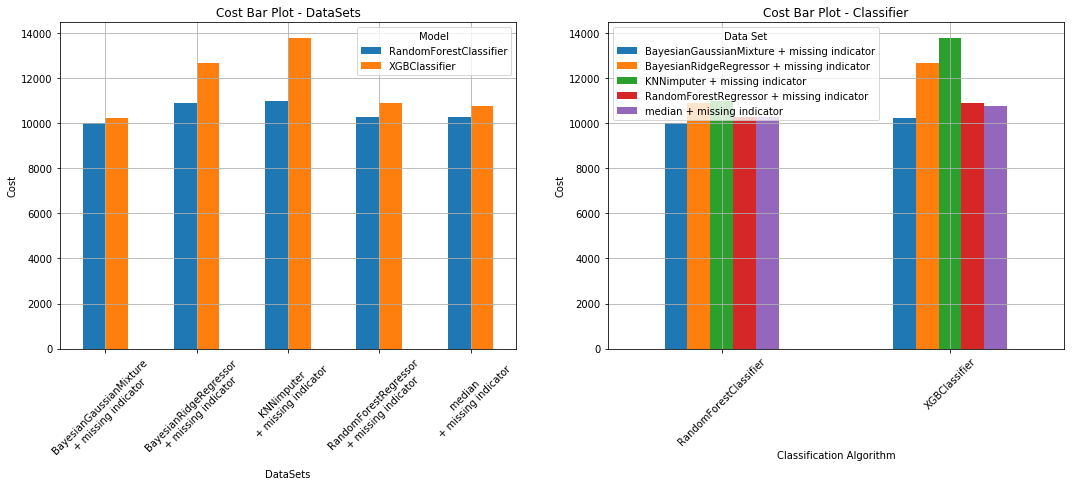

In [6]:
#selecting results rows corresponding to Feature Engineering with missing indicator
results2 = results[results['Feature Engineering']=='missing indicator']

#grouped barplot https://stackoverflow.com/a/47797080/11479173
#rotate xtick labels https://stackoverflow.com/a/43153984/11479173
#Text object(in Xticklabels) documentaion: https://matplotlib.org/api/text_api.html#matplotlib.text.Text.set_usetex

fig = plt.figure(figsize =(18, 6)) 

ax = fig.add_subplot(121)
results2.pivot('Data Set','Model', 'Cost').plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Cost Bar Plot - DataSets', xlabel='DataSets', ylabel='Cost' )
xtick_labels = ax.get_xticklabels()
xtick_labels = [text_obj.get_text().replace("+","\n+") for text_obj in list(xtick_labels)]
ax.set_xticklabels(xtick_labels, rotation = 45)

ax = fig.add_subplot(122)
results2.pivot('Model','Data Set', 'Cost').plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Cost Bar Plot - Classifier', xlabel='Classification Algorithm', ylabel='Cost' )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

plt.show()

from Cost Bar Plot - DataSets:
- Since only best performing classifiers RandomForest and XGBoost Classifiers are used, all the cost values are relatively lesser and also there is no significant difference in cost values.
- BayesianGaussianMixture imputer + missing indicator dataset performed better with both the classifiers.

from Cost Bar Plot - Classifier:
- RandomForestClassifier performed better than XGBClassifier for all datasets except median + missing indicator.

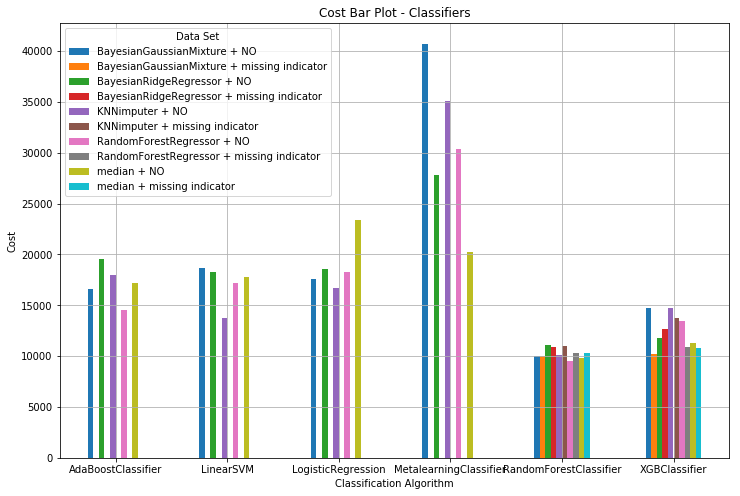

In [7]:
#grouped barplot https://stackoverflow.com/a/47797080/11479173
#rotate xtick labels https://stackoverflow.com/a/43153984/11479173
fig = plt.figure(figsize =(12, 8)) 
ax = fig.add_subplot(111)
results.pivot('Model','Data Set', 'Cost').plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Cost Bar Plot - Classifiers', xlabel='Classification Algorithm', ylabel='Cost' )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()

- The cost values obtained when datasets are trained with MetaLearnClassifier, AdaBoostClassifier, LogisticRegression and linearSVM are significantly higher than cost values for datasets trained with RandomForest and XGBoost Classifiers.

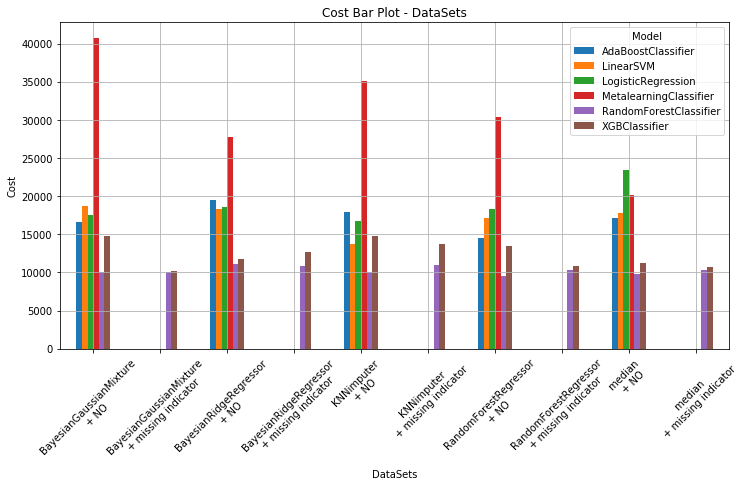

In [8]:
#grouped barplot https://stackoverflow.com/a/47797080/11479173
#rotate xtick labels https://stackoverflow.com/a/43153984/11479173
#Text object(in Xticklabels) documentaion: https://matplotlib.org/api/text_api.html#matplotlib.text.Text.set_usetex
fig = plt.figure(figsize =(12, 6)) 
ax = fig.add_subplot(111)
results.pivot('Data Set','Model', 'Cost').plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Cost Bar Plot - DataSets', xlabel='DataSets', ylabel='Cost' )
xtick_labels = ax.get_xticklabels()
xtick_labels = [text_obj.get_text().replace("+","\n+") for text_obj in list(xtick_labels)]
ax.set_xticklabels(xtick_labels, rotation = 45)
plt.show()

- While training with RandomForest and XGBoost Classifier, both imputed datasets and along with its concated missing indicator columns performed better with comparitively lesser cost values.